<a href="https://colab.research.google.com/github/matsunagalab/lecture_ML/blob/main/machine_learning_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第15回 ベイズ推論その2 ベイズ線形回帰

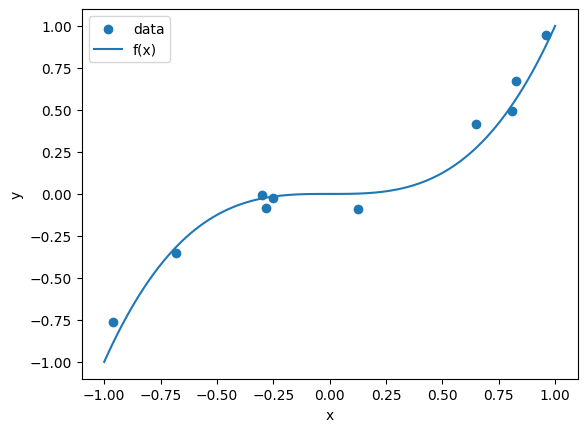

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 多項式の基底関数を定義
def polynomial_basis(x, M):
    N = len(x)
    X = np.zeros((N, M))
    for m in range(M):
        X[:, m] = x ** (m + 1)
    return X

# 多項式データの作成
N = 10
x = 2.0 * (np.random.rand(N) - 0.5)
x = np.sort(x)
sigma2_y = 0.01
X = polynomial_basis(x, 3)
w_truth = np.array([0.0, 0.0, 1.0])
f_truth = X @ w_truth
Y = f_truth + np.sqrt(sigma2_y) * np.random.randn(N)

# Plot data
x_range = np.linspace(-1, 1, 100)
plt.scatter(x, Y, label="data")
plt.plot(x_range, x_range**3, label="f(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

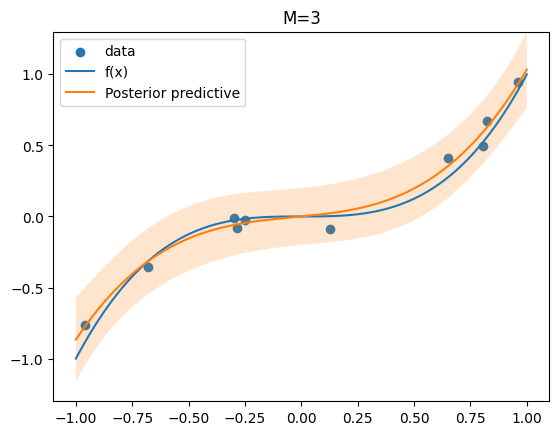

In [29]:
# ベイズ推論により予測分布を求める関数を定義
def bayes_inference(x, Y, M, sigma2_y, sigma2_w, x_range):
    X = polynomial_basis(x, M)
    N = len(x)
    I_N = np.eye(N)
    I_M = np.eye(M)
    # posterior
    sigma2_w_new = np.linalg.inv(X.T @ np.linalg.inv(sigma2_y * I_N) @ X + np.linalg.inv(sigma2_w * I_M))
    mu_w_new = sigma2_w_new @ (X.T @ np.linalg.inv(sigma2_y * I_N) @ Y)
    # predictive
    X_range = polynomial_basis(x_range, M)
    Y_prediction = mu_w_new.T @ X_range.T
    sigma2_y_prediction = sigma2_y + np.diag(X_range @ sigma2_w_new @ X_range.T)
    # evidence
    evidence = -0.5 * (np.sum(Y) / sigma2_y + N * np.log(sigma2_y) + N * np.log(2 * np.pi)
                       + np.log(sigma2_w) - mu_w_new.T @ np.linalg.inv(sigma2_w_new) @ mu_w_new
                       - np.linalg.slogdet(sigma2_w_new)[1])
    return Y_prediction, np.sqrt(sigma2_y_prediction), evidence

# ベイズ線形回帰
M = 3 # 多項式の次数. 好きに変えて遊んでみてください
x_range = np.linspace(-1, 1, 200)
sigma2_w = 1.0
bayes = bayes_inference(x, Y, M, sigma2_y, sigma2_w, x_range)
plt.scatter(x, Y, label="data")
plt.plot(x_range, x_range**3, label="f(x)")
plt.plot(x_range, bayes[0], label="Posterior predictive")
plt.fill_between(x_range, bayes[0] - 2*bayes[1], bayes[0] + 2*bayes[1], alpha=0.2)
plt.ylim([-1.3, 1.3])
plt.legend()
plt.title(f"M={M}")
plt.show()

Evidence: [63.733125154092846, 61.94626655342989, 68.655789438055, 67.4600716889311, 66.7742022656312, 66.2314846582436, 65.77056451572119, 65.42916154331887, 65.11080510148538, 64.86982155272736]


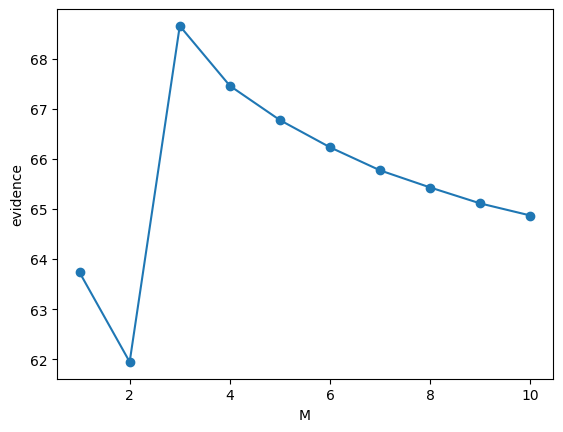

In [27]:
# エビデンスを用いたモデル選択
bayes_array = [bayes_inference(x, Y, m, sigma2_y, sigma2_w, x_range) for m in range(1, 11)]
evidence = [bayes_array[m][2] for m in range(10)]
print("Evidence:", evidence)
plt.plot(range(1, 11), evidence, marker='o')
plt.xlabel("M")
plt.ylabel("evidence")
plt.show()

応用: PyMCを用いた事後分布の計算

In [24]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

M = 3

# Model specification
with pm.Model() as model:
    # Priors
    sigma = pm.HalfNormal('sigma', sigma=1.0)
    W = pm.Normal('W', 0, sigma=20.0, shape=M)

    # Expected value of outcome
    mu = pm.math.dot(W, np.asarray([x**i for i in range(1, M+1)]))

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)

    # Posterior distribution
    idata = pm.sample()

array([<Axes: title={'center': 'W\n0'}>, <Axes: title={'center': 'W\n1'}>,
       <Axes: title={'center': 'W\n2'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

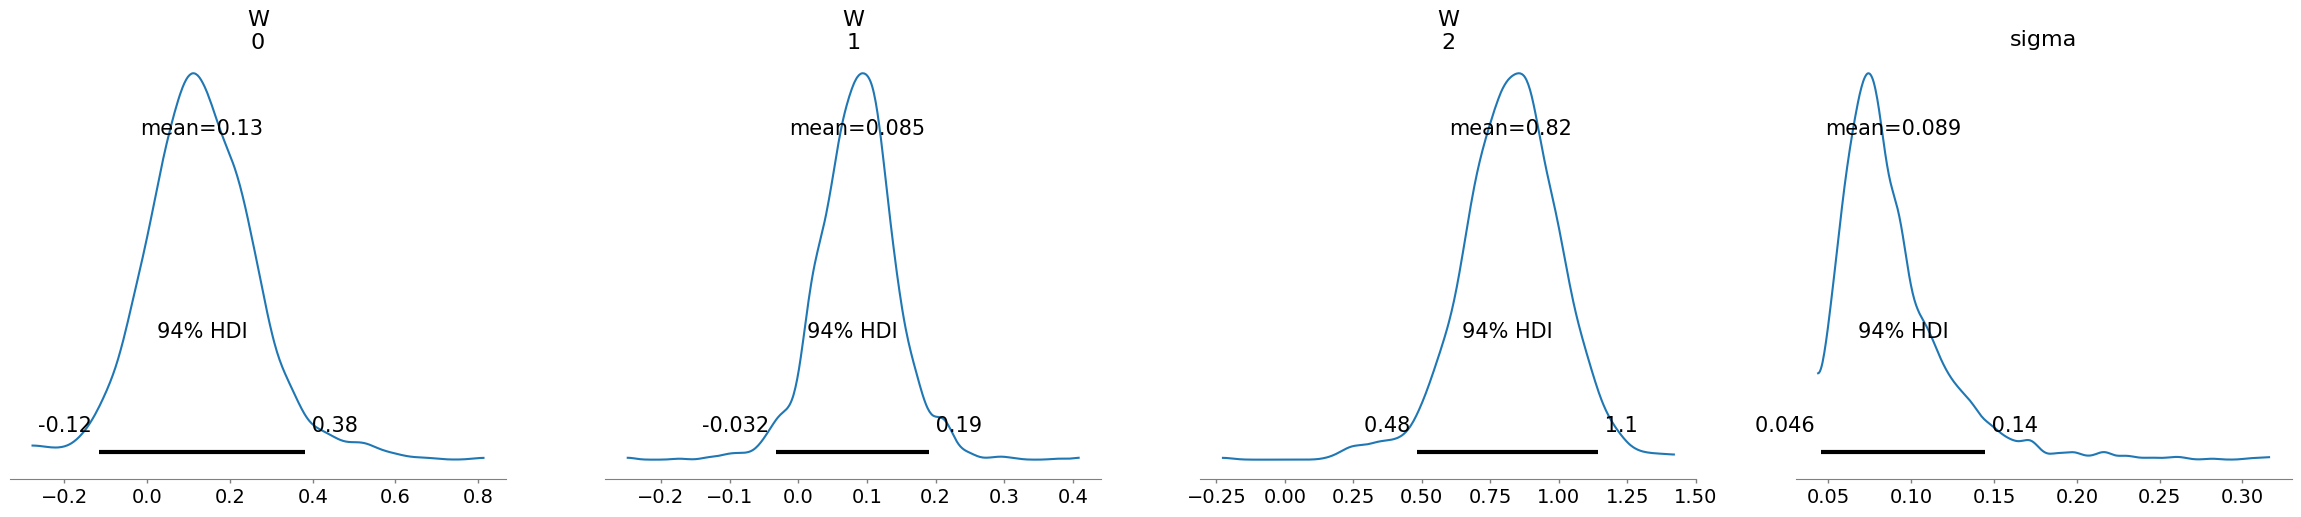

In [25]:
import arviz as az
#az.plot_trace(idata)
#az.plot_forest(idata)
az.plot_posterior(idata)